In [1]:
% Ensemble Kalman Smoothing (fixed-lag) implementation
clear;
close all;

## load data: forward problem

In [2]:
inputname1 = './data_transient/transient_1d_conduction_pulse1.mat';
load(inputname1,'time_grid','T_transient','R_transient','q_transient');

% original solutions
time_grid_solution = time_grid;
T_transient_solution = T_transient;
R_transient_solution = R_transient;
q_transient_solution = q_transient;

## hyperparameter settings smoothing method

In [3]:
rng('default');
M_sample = 50; % INPUT
sigma_noise = 0.1; % [K] INPUT noise magnitude
q_noise = 10^8; % [W/m^3] INPUT 10^5
Rgap_noise = 0.1; % [ratio] INPUT error physics modeling on Rgap
r_step = 3; % needs to be larger than 1 (=filtering)
fprintf('r step = %d (smoothing > 1, filtering = 1) \n', r_step);

r step = 3 (smoothing > 1, filtering = 1)

## geometry

In [4]:
ro_heater = 4.25*10^-3; % [m]
ro_zro2 = 30.70*10^-3; % [m] instead of 30.734 mm
dr = 0.05*10^-3; % [m] grid size: can be greater than greatest common divisor of two lengths

r_grid_heater = linspace(0, ro_heater, 1+ro_heater/dr)'; % including interface
r_grid_zro2 = linspace(ro_heater, ro_zro2, 1+(ro_zro2-ro_heater)/dr)'; % including interface
r_grid_total = linspace(0, ro_zro2, 1+ro_zro2/dr)';
N_grid_heater = length(r_grid_heater);
N_grid_total = length(r_grid_total);

## temperature sensor placement (index)

In [5]:
% sensor_user_input = [100];
sensor_user_input = [146];

Nsensor = length(sensor_user_input);
Hobs = zeros(Nsensor, N_grid_total + 1); % observation matrix for augmented state [T, q]
for i = 1:Nsensor % Fill in the observation matrix
    Hobs(i, sensor_user_input(i)) = 1;
end
Gamma = diag(sigma_noise * ones(1, Nsensor)); % noise covariance matrix

## Inverse time steps

In [6]:
time_end = 100; % [s] INPUT last time
dt = 1; % [s] INPUT inverse time step size
time_grid = linspace(0, time_end, 1+time_end/dt)';
N_time = length(time_grid);

## translate original data onto inverse time step

In [7]:
T_transient_solution = myLinearInterp(time_grid_solution, T_transient', time_grid)';
R_transient_solution = myLinearInterp(time_grid_solution, R_transient, time_grid);
q_transient_solution = myLinearInterp(time_grid_solution, q_transient, time_grid);
noise = sigma_noise * randn([size(T_transient_solution) M_sample]); % Generating Gaussian noise
T_transient_solution_noisy =  repmat(T_transient_solution, [1, 1, M_sample]) + noise; % Adding the noise to the data matrix

## matrix (for individual sample): state, thermal properties, data

In [8]:
T_transient_sample = zeros(N_grid_total, N_time, M_sample);
q_transient_sample = zeros(N_time, M_sample);
R_transient_sample = zeros(N_time, M_sample); % [m^2-K/W]
Yobs_sample = zeros(Nsensor, N_time, M_sample);
Yobs_sample = repmat(Hobs(:,1:end-1)*T_transient_solution_noisy(:,1:N_time), [1, 1, M_sample]) + sigma_noise*randn(Nsensor, N_time, M_sample); % corrupted measurement

k_i = zeros(N_grid_total, M_sample); % thermal conductivity at node i
rhocp_i = zeros(N_grid_total, M_sample); % rho*c_p at node i
k_i_face = zeros(N_grid_total-1, M_sample); % correspond to i+1/2 location

## prediction = before Kamlan correction

In [9]:
T_pred_sample = zeros(N_grid_total, N_time, M_sample);

## estimation = after Kamlan correction

In [10]:
T_est_sample = zeros(N_grid_total, N_time, M_sample);

## smoothing = backward correction

In [11]:
T_sm_sample = zeros(N_grid_total, N_time, M_sample);
T_transient_sm_mean = zeros(N_grid_total, N_time);
q_transient_sm_mean = zeros(N_time, 1);
R_transient_sm_mean = zeros(N_time, 1);
T_transient_sm_std = zeros(N_grid_total, N_time);
q_transient_sm_std = zeros(N_time, 1);
R_transient_sm_std = zeros(N_time, 1);

## statistics

In [12]:
Cov_MC_temp = zeros(N_grid_total+1, N_grid_total+1); % estimated covariance (updated each time step)
Var_MC = zeros(N_grid_total+1, N_time); % store variance of each state
K_MC = zeros(N_grid_total+1, Nsensor, N_time); % Kalman gain
state_augmented_sample_temp = zeros(N_grid_total+1, M_sample);

C_back_temp = zeros(N_grid_total+1, N_grid_total+1); % for backward pass calculation
Cov_temp_pred = zeros(N_grid_total+1, N_grid_total+1); % covariance predicted state
Cov_temp_est = zeros(N_grid_total+1, N_grid_total+1); % covariance estimated state
state_sample_temp_pred = zeros(N_grid_total+1, M_sample);
state_sample_temp_est = zeros(N_grid_total+1, M_sample);
state_sample_temp_sm = zeros(N_grid_total+1, M_sample);

## physical properties

In [13]:
T_outer = 500 + 273.15; % [K] boundary condition

## initialization (t=0)

In [14]:
it = 1;
fprintf('initialization (time: %d second) \n', time_grid(it));

initialization (time: 0 second)

In [15]:

T_transient_sample(:,it,:) = T_outer;
state_augmented_sample_temp(1:end-1, :) = T_transient_sample(:,it,:);
state_augmented_sample_temp(end, :) = q_transient_sample(it,:);
Cov_MC_temp = cov(state_augmented_sample_temp');

idx = 1:N_grid_heater-1; % heater
k_i(idx,:) = k_T_heater(T_outer); % use kelvin for input temperature
rhocp_i(idx,:) = rhocp_T_heater(T_outer);

idx = N_grid_heater; % gap
R_transient_sample(it,:) = Rgap_T(T_outer)*(1 + Rgap_noise*randn(1,M_sample));
k_i(idx,:) = 1./(0.5/k_T_heater(T_outer) + 0.5/k_T_zro2(T_outer) + R_transient_sample(it,:)/dr);
rhocp_i(idx,:) = 0.5*(rhocp_T_heater(T_outer) + rhocp_T_zro2(T_outer));

idx = N_grid_heater+1:N_grid_total; % zro2
k_i(idx,:) = k_T_zro2(T_outer);
rhocp_i(idx,:) = rhocp_T_zro2(T_outer);

k_i_face = 1./(0.5./k_i(1:end-1,:) + 0.5./k_i(2:end, :));
% face #1: (1,2), face #2: (2,3), face #(N_grid_total-1):(N_grid_total-1, N_grid_total)

Var_MC(:, it) = sqrt(diag(Cov_MC_temp));

T_transient_sm_mean(:,it) = mean(T_transient_sample(:,it,:), 3);
q_transient_sm_mean(it) = mean(q_transient_sample(it,:));
R_transient_sm_mean(it) = mean(R_transient_sample(it,:));
T_transient_sm_std(:,it) =  std(T_transient_sample(:,it,:), 0, 3);
q_transient_sm_std(it) = std(q_transient_sample(it,:), 0);
R_transient_sm_std(it) = std(R_transient_sample(it,:), 0);

T_pred_sample = T_transient_sample;
q_pred_sample = q_transient_sample;
R_pred_sample = R_transient_sample; % [m^2-K/W]
T_est_sample = T_transient_sample;
q_est_sample = q_transient_sample;
R_est_sample = R_transient_sample; % [m^2-K/W]
T_sm_sample = T_transient_sample;
q_sm_sample = q_transient_sample;
R_sm_sample = R_transient_sample; % [m^2-K/W]

## solve inverse problem (t>0)

In [16]:
for it=2:N_time-r_step+1
    fprintf('time: %d second \n', time_grid(it));

    for ir=1:r_step % ir=1 is using current state
        fprintf(' ir=%d> ',ir)

time: 1 second 
 ir=1>  ir=2>  ir=3> 
time: 2 second 
 ir=1>  ir=2>  ir=3> 
time: 3 second 
 ir=1>  ir=2>  ir=3> 
time: 4 second 
 ir=1>  ir=2>  ir=3> 
time: 5 second 
 ir=1>  ir=2>  ir=3> 
time: 6 second 
 ir=1>  ir=2>  ir=3> 
time: 7 second 
 ir=1>  ir=2>  ir=3> 
time: 8 second 
 ir=1>  ir=2>  ir=3> 
time: 9 second 
 ir=1>  ir=2>  ir=3> 
time: 10 second 
 ir=1>  ir=2>  ir=3> 
time: 11 second 
 ir=1>  ir=2>  ir=3> 
time: 12 second 
 ir=1>  ir=2>  ir=3> 
time: 13 second 
 ir=1>  ir=2>  ir=3> 
time: 14 second 
 ir=1>  ir=2>  ir=3> 
time: 15 second 
 ir=1>  ir=2>  ir=3> 
time: 16 second 
 ir=1>  ir=2>  ir=3> 
time: 17 second 
 ir=1>  ir=2>  ir=3> 
time: 18 second 
 ir=1>  ir=2>  ir=3> 
time: 19 second 
 ir=1>  ir=2>  ir=3> 
time: 20 second 
 ir=1>  ir=2>  ir=3> 
time: 21 second 
 ir=1>  ir=2>  ir=3> 
time: 22 second 
 ir=1>  ir=2>  ir=3> 
time: 23 second 
 ir=1>  ir=2>  ir=3> 
time: 24 second 
 ir=1>  ir=2>  ir=3> 
time: 25 second 
 ir=1>  ir=2>  ir=3> 
time: 26 second 
 ir=1>  ir=2>  ir

## evolution heat source (process noise)

In [17]:
        q_transient_sample(it+ir-1,:) = q_transient_sample(it-1+ir-1, :) + q_noise*randn(1,M_sample);

    for m=1:M_sample % for each sample

## assign matrix values

In [18]:
        A = sparse(N_grid_total, N_grid_total); % new time step
        B = sparse(N_grid_total, N_grid_total); % prev time step
        C = sparse(N_grid_total, 1); % source term

## discretization for T equation

In [19]:
        % center symmetry line
        idx = 1;
        A(idx, idx) = 4*k_i_face(idx,m) + rhocp_i(idx,m)/dt*dr^2;
        A(idx, idx+1) = -4*k_i_face(idx,m);
        B(idx, idx) = rhocp_i(idx,m)/dt*dr^2;
        C(idx) = q_transient_sample(it+ir-1, m)*dr^2; % keep using the one from previous time step
        % intermediate
        idx = 2:(N_grid_total - 1);
        vector_idx = idx + (idx - 1)*N_grid_total;
        A(vector_idx) = (k_i_face(idx,m)+k_i_face(idx-1,m)) + (k_i_face(idx,m)-k_i_face(idx-1,m))/2./r_grid_total(idx)*dr + rhocp_i(idx,m)/dt*dr^2; % [i, i]
        A(vector_idx+N_grid_total) = -k_i_face(idx,m) - k_i_face(idx,m)/2./r_grid_total(idx)*dr; % [i, i+1]
        A(vector_idx-N_grid_total) = -k_i_face(idx-1,m) + k_i_face(idx-1,m)/2./r_grid_total(idx)*dr; % [i, i-1]
        B(vector_idx) = rhocp_i(idx,m)/dt*dr^2;
        idx = 2:N_grid_heater-1; % heat source from heater (excluding gap)
        C(idx) = q_transient_sample(it+ir-1, m)*dr^2;
        C(N_grid_heater) = 1/2*q_transient_sample(it+ir-1, m)*dr^2;
        % outer boundary
        idx = N_grid_total;
        A(idx, idx) = 1;
        C(idx) = T_outer;
        % solve transient equation
        T_transient_sample(:,it+ir-1,m) = A\(B*T_transient_sample(:,it-1+ir-1,m) + C);
    end
    % save samples
    T_pred_sample(:,it+ir-1,:) = T_transient_sample(:,it+ir-1,:);
    q_pred_sample(it+ir-1,:) = q_transient_sample(it+ir-1,:);
    R_pred_sample(it+ir-1,:) = R_transient_sample(it-1+ir-1,:);

    % augmented state
    state_augmented_sample_temp(1:end-1, :) = T_transient_sample(:,it+ir-1,:);
    state_augmented_sample_temp(end, :) = q_transient_sample(it+ir-1,:);
    Cov_MC_temp = cov(state_augmented_sample_temp');
    % Kalman gain and update
    K_MC(:,:,it+ir-1) = Cov_MC_temp*Hobs'*inv(Gamma + Hobs*Cov_MC_temp*Hobs');

    % assimilate individual result
    for m=1:M_sample % for each sample
    state_augmented_sample_temp(:,m) = ...
        state_augmented_sample_temp(:,m) + K_MC(:,:,it+ir-1)*(Yobs_sample(:,it+ir-1,m) - Hobs*state_augmented_sample_temp(:,m));
    end

    % assign values
    T_transient_sample(:,it+ir-1,:) = state_augmented_sample_temp(1:end-1, :);
    q_transient_sample(it+ir-1, :) = state_augmented_sample_temp(end, :);

## properties for next time step (one\-level scheme)

In [20]:
    for m=1:M_sample % for each sample
        idx = 1:N_grid_heater-1; % heater
        k_i(idx,m) = k_T_heater(T_transient_sample(idx,it+ir-1,m)); % use kelvin for input temperature
        rhocp_i(idx,m) = rhocp_T_heater(T_transient_sample(idx,it+ir-1,m));

        idx = N_grid_heater; % gap
        R_transient_sample(it+ir-1,m) = Rgap_T(T_transient_sample(idx,it+ir-1,m))*(1 + Rgap_noise*randn());
        k_i(idx,m) = 1/(0.5/k_T_heater(T_transient_sample(idx,it+ir-1,m)) + 0.5/k_T_zro2(T_transient_sample(idx,it+ir-1,m)) + R_transient_sample(it+ir-1,m)/dr);
        rhocp_i(idx,m) = 0.5*( rhocp_T_heater(T_transient_sample(idx,it+ir-1,m)) + rhocp_T_zro2(T_transient_sample(idx,it+ir-1,m)) );

        idx = N_grid_heater+1:N_grid_total; % zro2
        k_i(idx,m) = k_T_zro2(T_transient_sample(idx,it+ir-1,m));  % use kelvin for input temperature
        rhocp_i(idx,m) = rhocp_T_zro2(T_transient_sample(idx,it+ir-1,m));

        k_i_face(:,m) = 1./(0.5./k_i(1:end-1,m) + 0.5./k_i(2:end,m));
    end

    % save samples
    T_est_sample(:,it+ir-1,:) = T_transient_sample(:,it+ir-1,:);
    q_est_sample(it+ir-1,:) = q_transient_sample(it+ir-1,:);
    R_est_sample(it+ir-1,:) = R_transient_sample(it+ir-1,:);
    end

## backward correction step

In [21]:
    for ir=r_step-1:-1:1
    fprintf(' <ir=%d ',ir)

    % augmented state of prediction (next)
    state_sample_temp_pred(1:end-1, :) = T_pred_sample(:,it+ir,:);
    state_sample_temp_pred(end, :) = q_pred_sample(it+ir,:);

    if ir == r_step-1
    % augmented state of correction (next)
    state_sample_temp_sm(1:end-1, :) = T_est_sample(:,it+ir,:);
    state_sample_temp_sm(end, :) = q_est_sample(it+ir,:);
    elseif ir < r_step-1
    % augmented state of backward (next)
    state_sample_temp_sm(1:end-1, :) = T_sm_sample(:,it+ir,:);
    state_sample_temp_sm(end, :) = q_sm_sample(it+ir,:);
    end

    % augmented state of correction (current)
    state_sample_temp_est(1:end-1, :) = T_est_sample(:,it+ir-1,:);
    state_sample_temp_est(end, :) = q_est_sample(it+ir-1,:);

    % covariance of correction (current)
    Cov_temp_est = cov(state_sample_temp_est');

    % covariance of prediction (next)
    Cov_temp_pred = cov(state_sample_temp_pred');

    % F (current)
    state_mean_temp_est = mean(state_sample_temp_est, 2);
    F_temp = Jacobian_expression_augmented_constproperty_f(state_mean_temp_est, dt);
    C_back_temp = Cov_temp_est*F_temp'*pinv(Cov_temp_pred);

    % calculate backward pass
    state_sample_back = state_sample_temp_est + C_back_temp*(state_sample_temp_sm - state_sample_temp_pred);

    % assign values
    T_sm_sample(:,it+ir-1,:) = state_sample_back(1:end-1, :);
    q_sm_sample(it+ir-1, :) = state_sample_back(end, :);

    % mean and std
    T_transient_sm_mean(:,it+ir-1) =  mean(T_sm_sample(:,it+ir-1,:), 3);
    q_transient_sm_mean(it+ir-1) = mean(q_sm_sample(it+ir-1,:));
    T_transient_sm_std(:,it+ir-1) =  std(T_sm_sample(:,it+ir-1,:), 0, 3);
    q_transient_sm_std(it+ir-1) = std(q_sm_sample(it+ir-1,:), 0);

    end
    fprintf('\n')

    % update the latest state for next time step
    T_transient_sample(:,it,:) = T_sm_sample(:,it,:);
    q_transient_sample(it, :) = q_sm_sample(it, :);

    % properties for next time step (one-level scheme)
    for m=1:M_sample % for each sample
        idx = 1:N_grid_heater-1; % heater
        k_i(idx,m) = k_T_heater(T_transient_sample(idx,it,m)); % use kelvin for input temperature
        rhocp_i(idx,m) = rhocp_T_heater(T_transient_sample(idx,it,m));

        idx = N_grid_heater; % gap
        R_transient_sample(it,m) = Rgap_T(T_transient_sample(idx,it,m))*(1 + Rgap_noise*randn());
        k_i(idx,m) = 1/(0.5/k_T_heater(T_transient_sample(idx,it,m)) + 0.5/k_T_zro2(T_transient_sample(idx,it,m)) + R_transient_sample(it,m)/dr);
        rhocp_i(idx,m) = 0.5*( rhocp_T_heater(T_transient_sample(idx,it,m)) + rhocp_T_zro2(T_transient_sample(idx,it,m)) );

        idx = N_grid_heater+1:N_grid_total; % zro2
        k_i(idx,m) = k_T_zro2(T_transient_sample(idx,it,m));  % use kelvin for input temperature
        rhocp_i(idx,m) = rhocp_T_zro2(T_transient_sample(idx,it,m));

        k_i_face(:,m) = 1./(0.5./k_i(1:end-1,m) + 0.5./k_i(2:end,m));
    end

    R_sm_sample(it,:) = R_transient_sample(it,:);
    R_transient_sm_mean(it) = mean(R_sm_sample(it, :));
    R_transient_sm_std(it) = std(R_sm_sample(it, :), 0);

end

 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <ir=1 
 <ir=2  <i

## calculate reconstruction errors

In [22]:
id_plot = 1:N_time-r_step+1; % for all inverse time steps

% heat source
q_transient_diff = q_transient_sm_mean(id_plot) - q_transient_solution(id_plot); % discrepancy vector
q_error_normalized = mean(abs(q_transient_diff))/mean(q_transient_solution); % bias (normalized)
q_std_normalized = mean(q_transient_sm_std)/mean(q_transient_solution); % std (normalized)

% peak temperature
id_peak = 1;
T_peak_error = mean(abs(T_transient_sm_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot))); % bias
T_peak_std = mean(T_transient_sm_std(id_peak,id_plot)); % std

fprintf('Δq/q0 = %.2f ± %.2f \n', q_error_normalized, q_std_normalized);

Δq/q0 = 0.13 ± 0.19

In [23]:
fprintf('ΔT(peak) = %.2f ± %.0f [K] \n', T_peak_error, T_peak_std);

ΔT(peak) = 5.07 ± 12 [K]

## plot result

In [24]:
fontsize = 14;
figure;
set(gcf, 'WindowState', 'maximized');

## heat source reconstruction


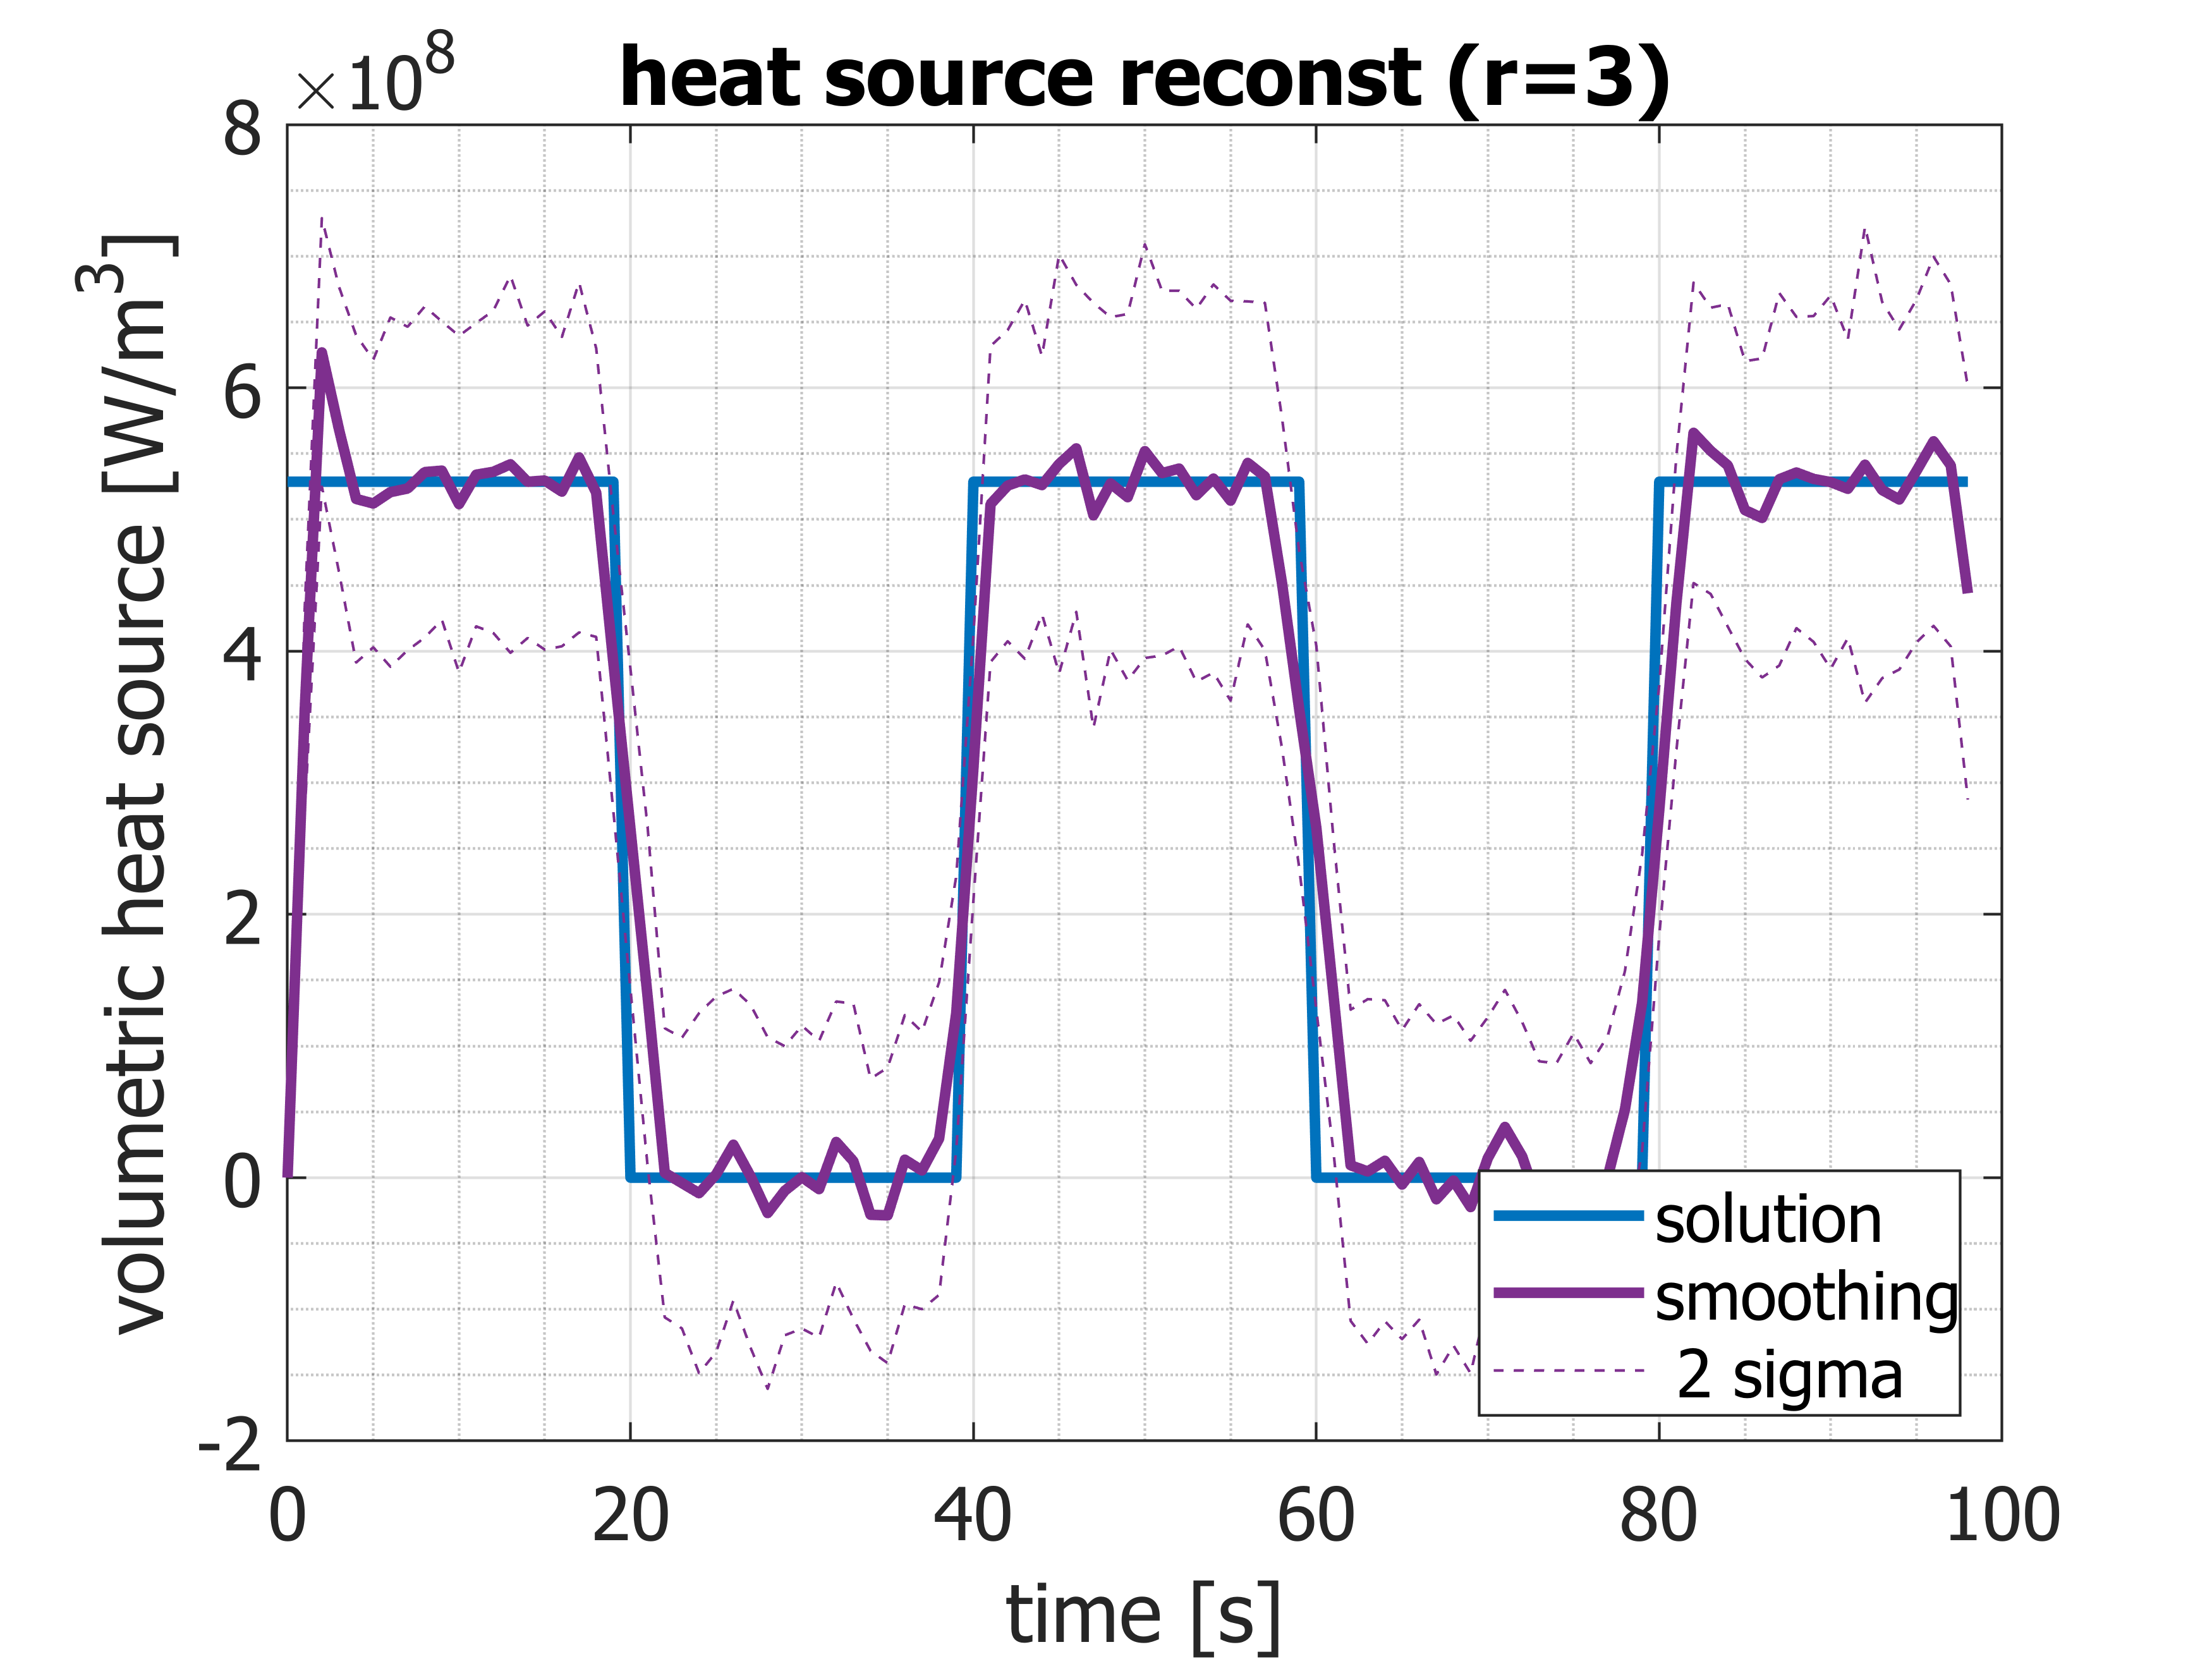

In [25]:
% subplot(2,3,1)
plot(time_grid(id_plot), q_transient_solution(id_plot),'Linewidth',2,'color','#0072BD','displayname','solution')
hold on
plot(time_grid(id_plot), q_transient_sm_mean(id_plot),'Linewidth',2,'color','#7E2F8E','displayname','smoothing')
hold on
plot(time_grid(id_plot), q_transient_sm_mean(id_plot) + 2*q_transient_sm_std(id_plot),'--','color','#7E2F8E','displayname',' 2 sigma')
hold on
plot(time_grid(id_plot), q_transient_sm_mean(id_plot) - 2*q_transient_sm_std(id_plot),'--','color','#7E2F8E','handlevisibility','off')

title("heat source reconst (r=" + num2str(r_step)+ ")")
xlabel('time [s]')
ylabel('volumetric heat source [W/m^3]')
legend('show','location','southeast')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## heat source reconstruction (discrepancy)


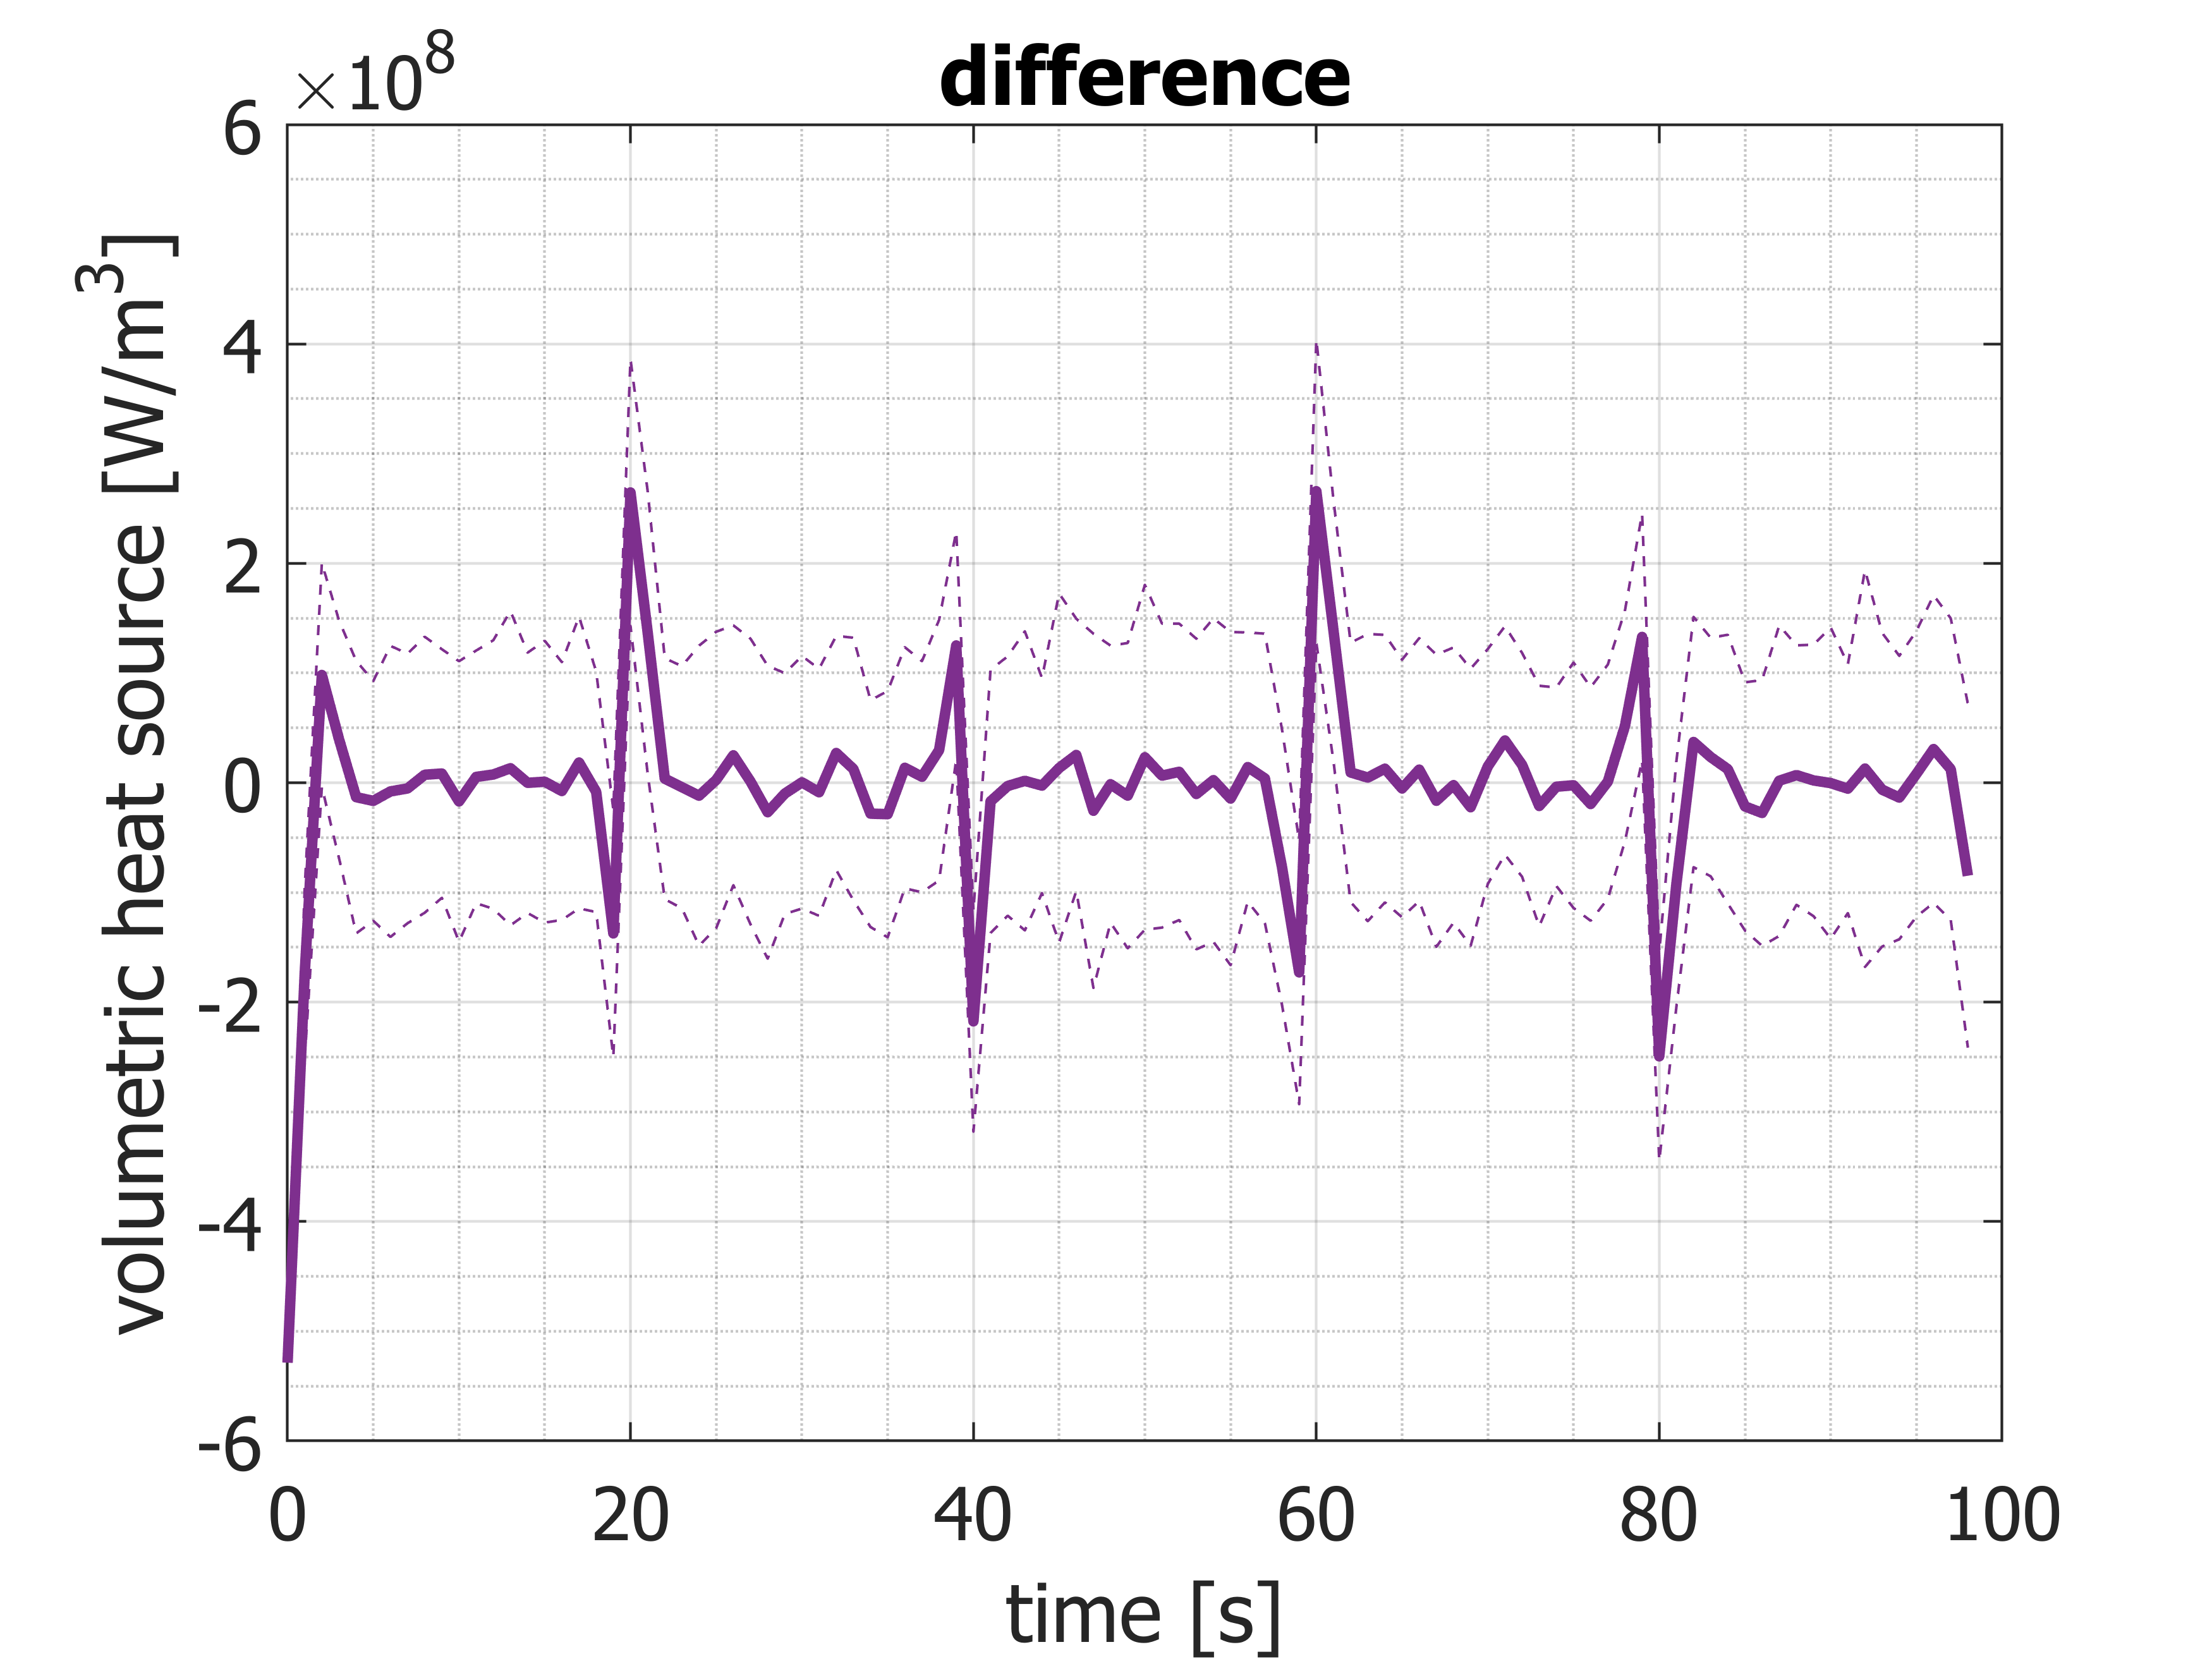

In [26]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), q_transient_sm_mean(id_plot) - q_transient_solution(id_plot),'Linewidth',2,'color','#7E2F8E')
hold on
plot(time_grid(id_plot), q_transient_sm_mean(id_plot) - q_transient_solution(id_plot) + 2*q_transient_sm_std(id_plot),'--','color','#7E2F8E')
hold on
plot(time_grid(id_plot), q_transient_sm_mean(id_plot) - q_transient_solution(id_plot) - 2*q_transient_sm_std(id_plot),'--','color','#7E2F8E')
title('difference')
xlabel('time [s]')
ylabel('volumetric heat source [W/m^3]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## peak temperature


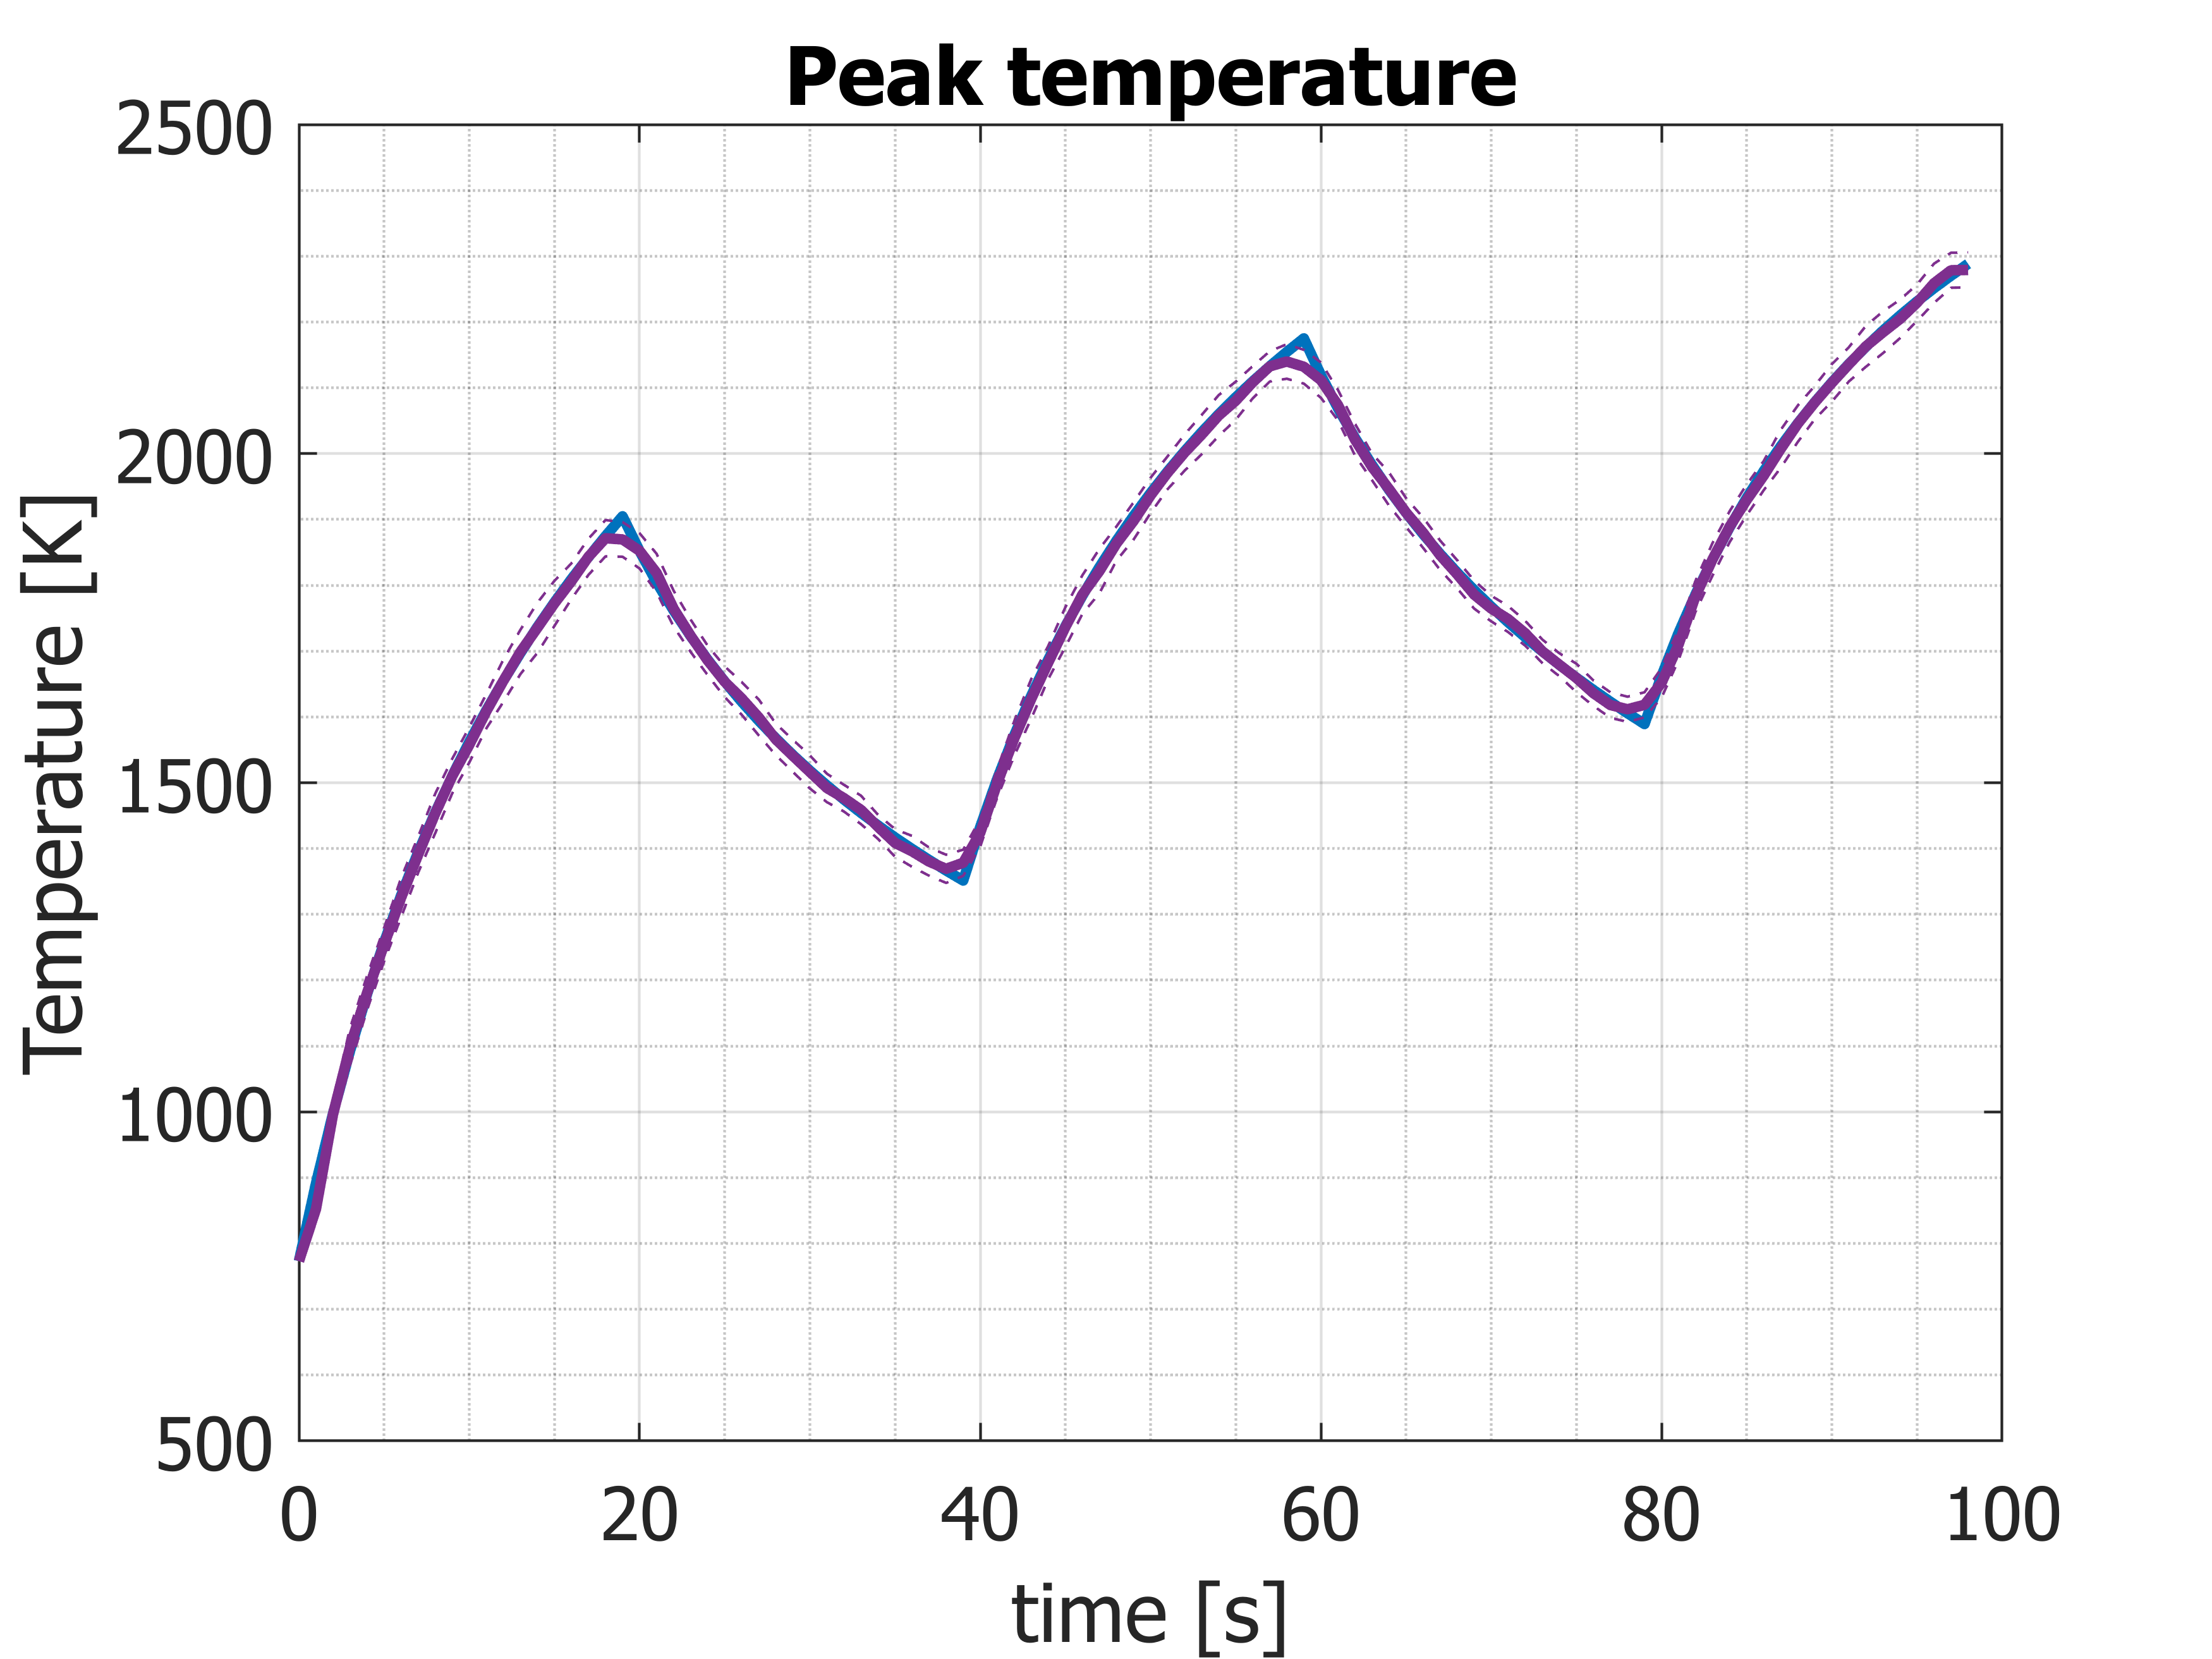

In [27]:
id_peak = 1;
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), T_transient_solution(id_peak,id_plot),'Linewidth',2,'color','#0072BD')
hold on
plot(time_grid(id_plot), T_transient_sm_mean(id_peak,id_plot),'Linewidth',2,'color','#7E2F8E')
hold on
plot(time_grid(id_plot), T_transient_sm_mean(id_peak,id_plot) + 2*T_transient_sm_std(id_peak,id_plot),'--','color','#7E2F8E')
hold on
plot(time_grid(id_plot), T_transient_sm_mean(id_peak,id_plot) - 2*T_transient_sm_std(id_peak,id_plot),'--','color','#7E2F8E')
title('Peak temperature')
xlabel('time [s]')
ylabel('Temperature [K]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor


## peak temperature (discrepancy)


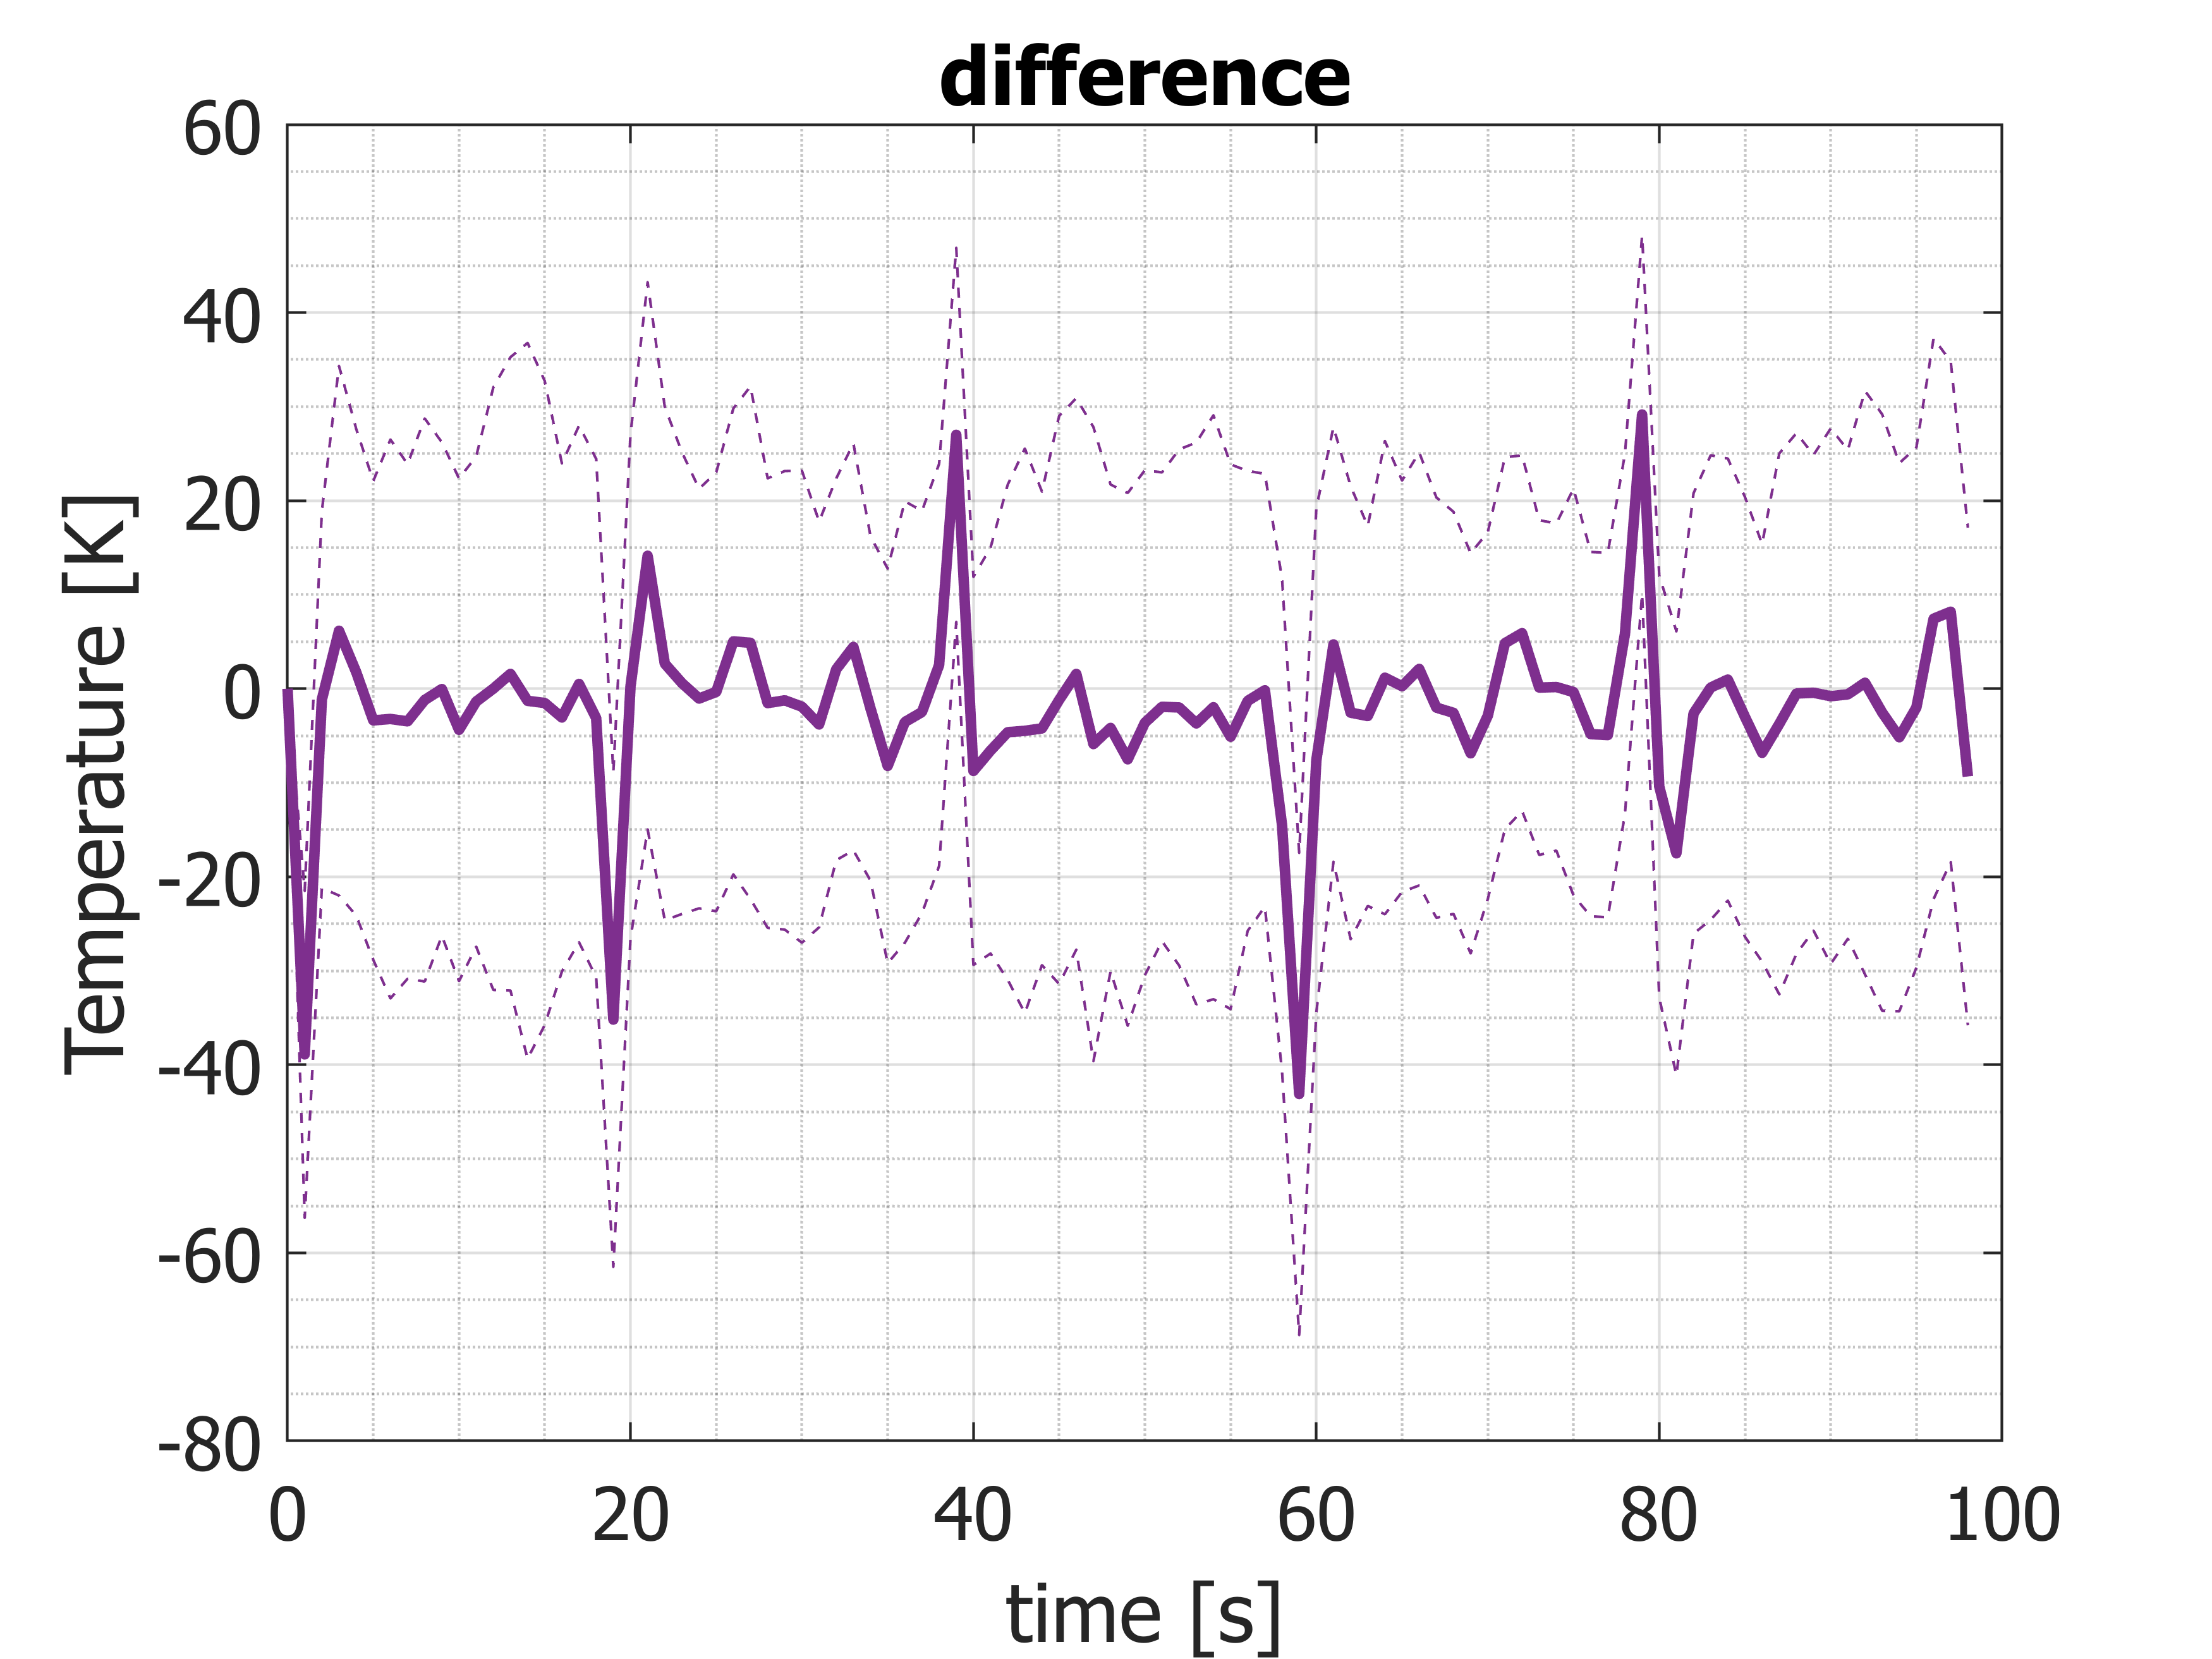

In [28]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), T_transient_sm_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot),'Linewidth',2,'color','#7E2F8E')
hold on
plot(time_grid(id_plot), T_transient_sm_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot) + 2*T_transient_sm_std(id_peak,id_plot),'--','color','#7E2F8E')
hold on
plot(time_grid(id_plot), T_transient_sm_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot) - 2*T_transient_sm_std(id_peak,id_plot),'--','color','#7E2F8E')
title('difference')
xlabel('time [s]')
ylabel('Temperature [K]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## gap thermal resistance


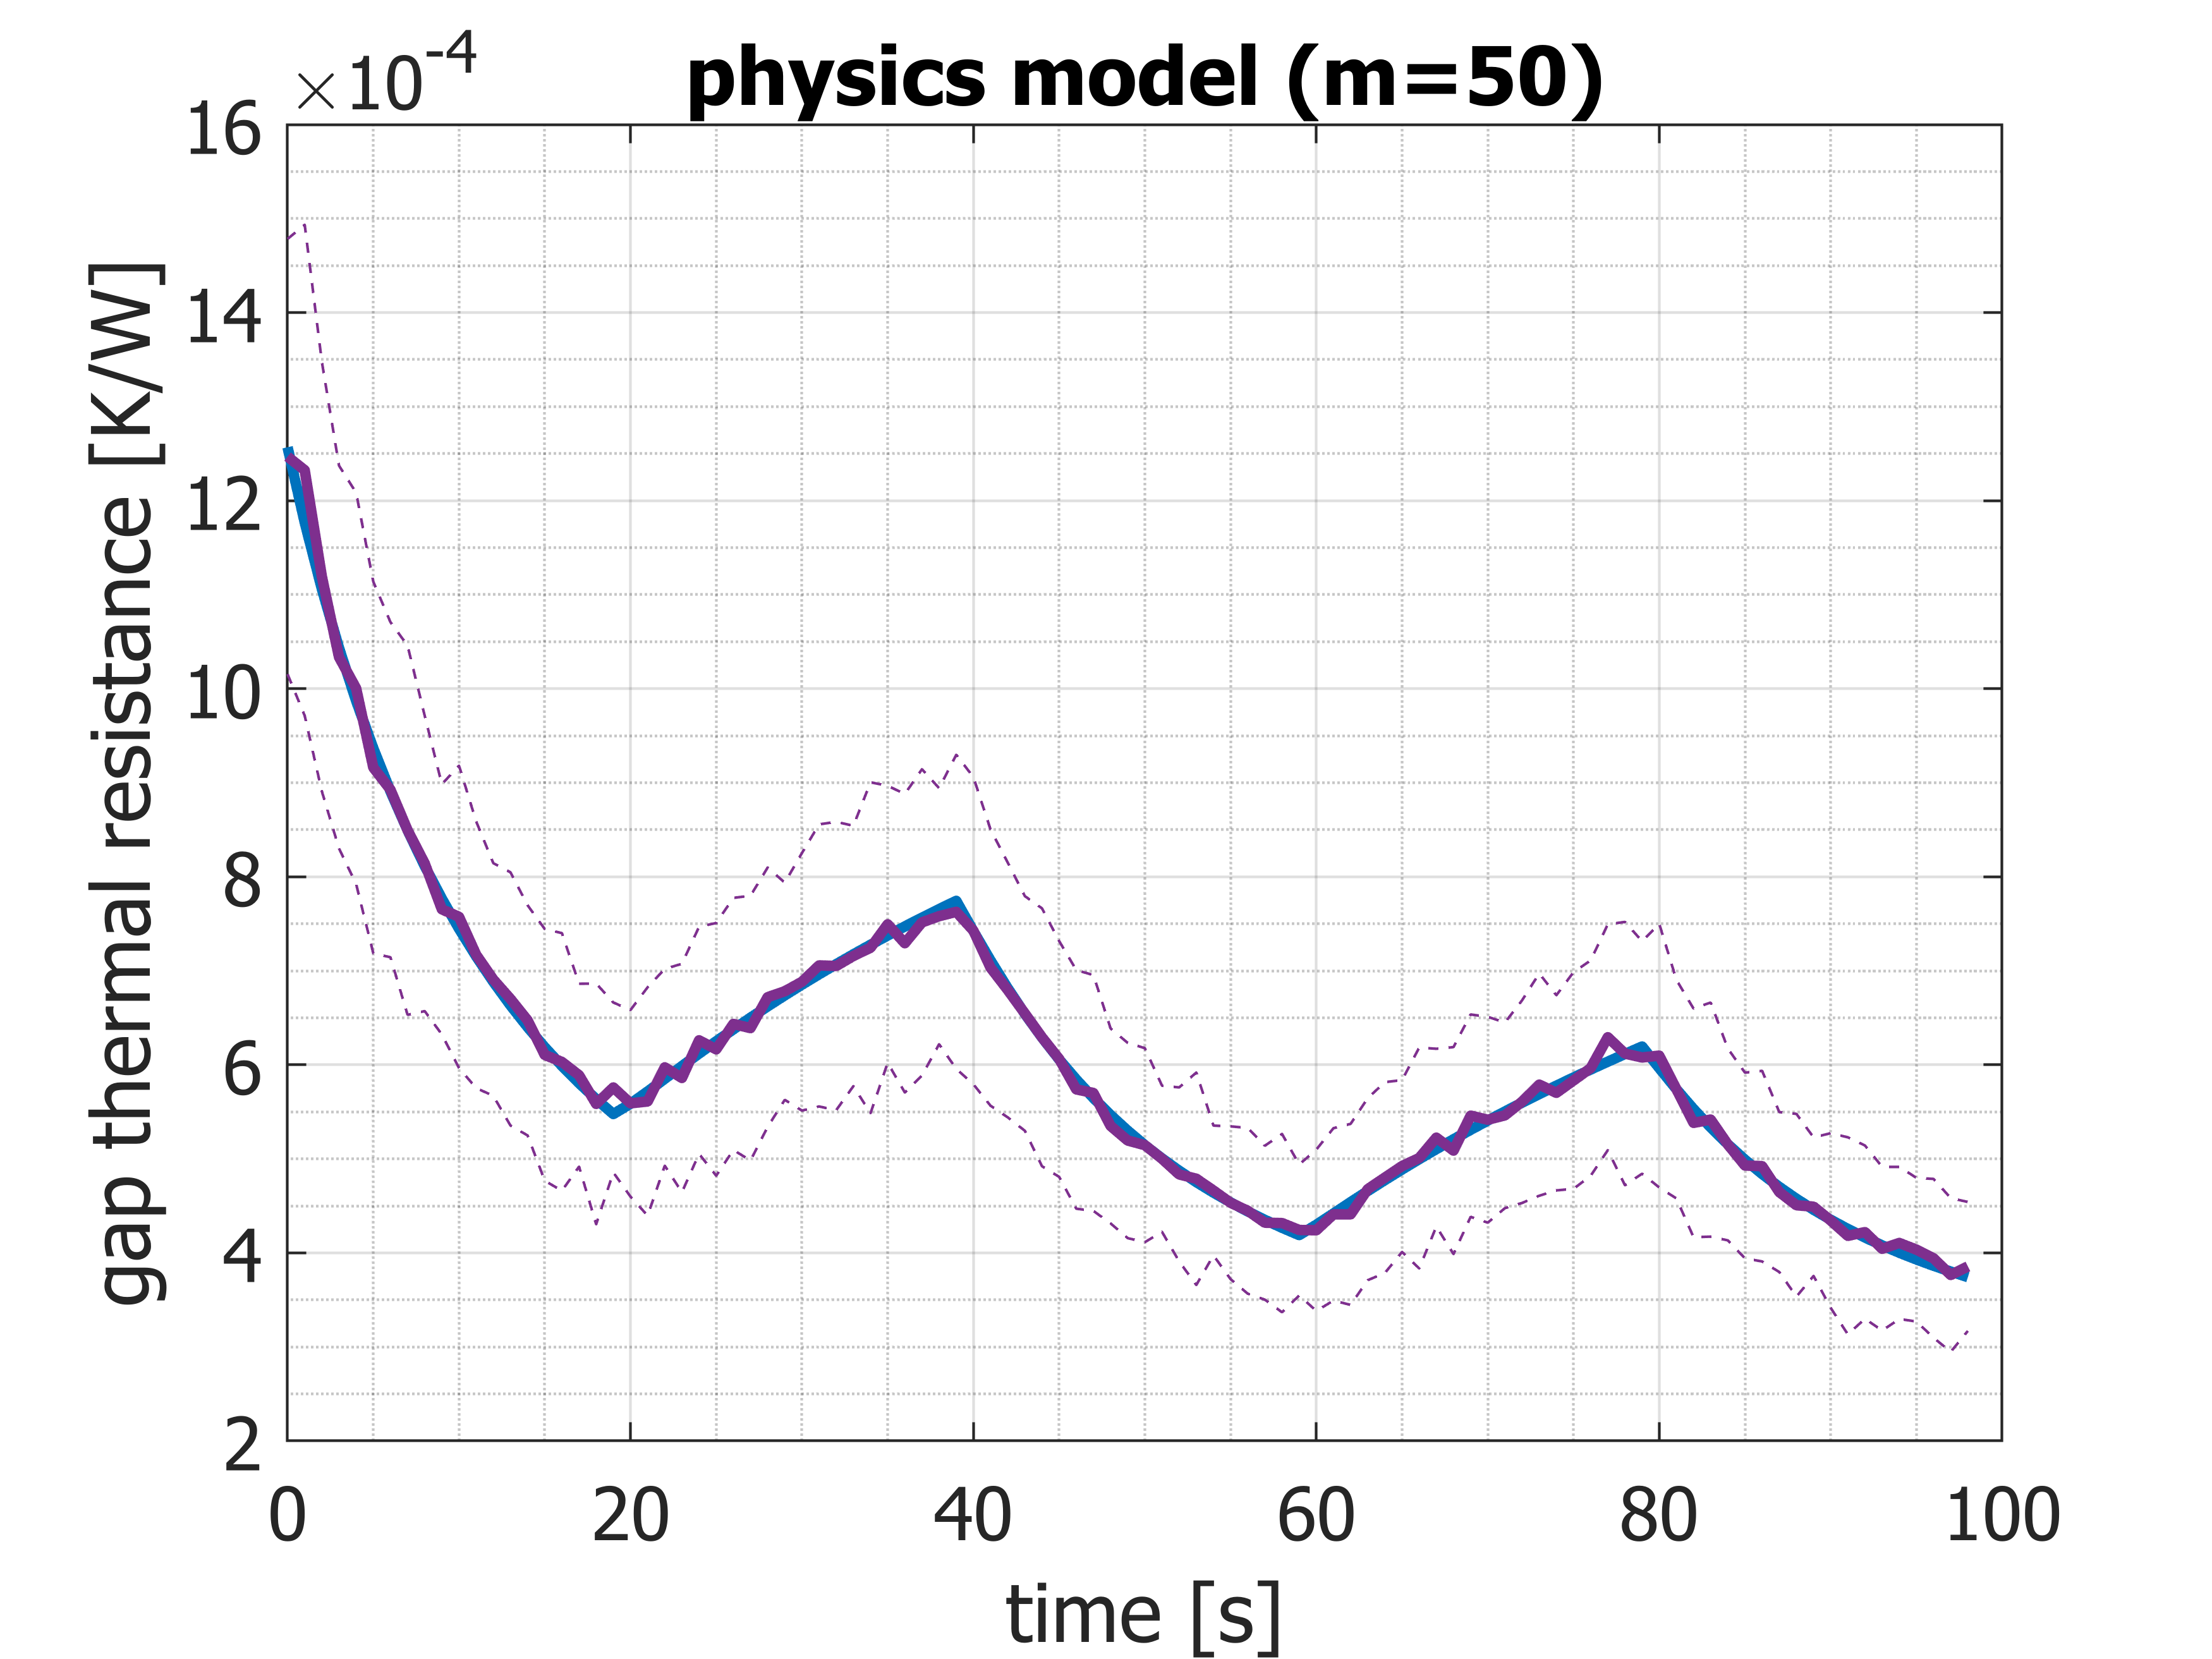

In [29]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), R_transient_solution(id_plot),'Linewidth',2,'color','#0072BD')
hold on
plot(time_grid(id_plot), R_transient_sm_mean(id_plot),'Linewidth',2,'color','#7E2F8E')
hold on
plot(time_grid(id_plot), R_transient_sm_mean(id_plot) + 2*R_transient_sm_std(id_plot),'--','color','#7E2F8E')
hold on
plot(time_grid(id_plot), R_transient_sm_mean(id_plot) - 2*R_transient_sm_std(id_plot),'--','color','#7E2F8E')

title("physics model (m=" + num2str(M_sample) + ")")
xlabel('time [s]')
ylabel('gap thermal resistance [K/W]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## 1D temperature profile at selected time step


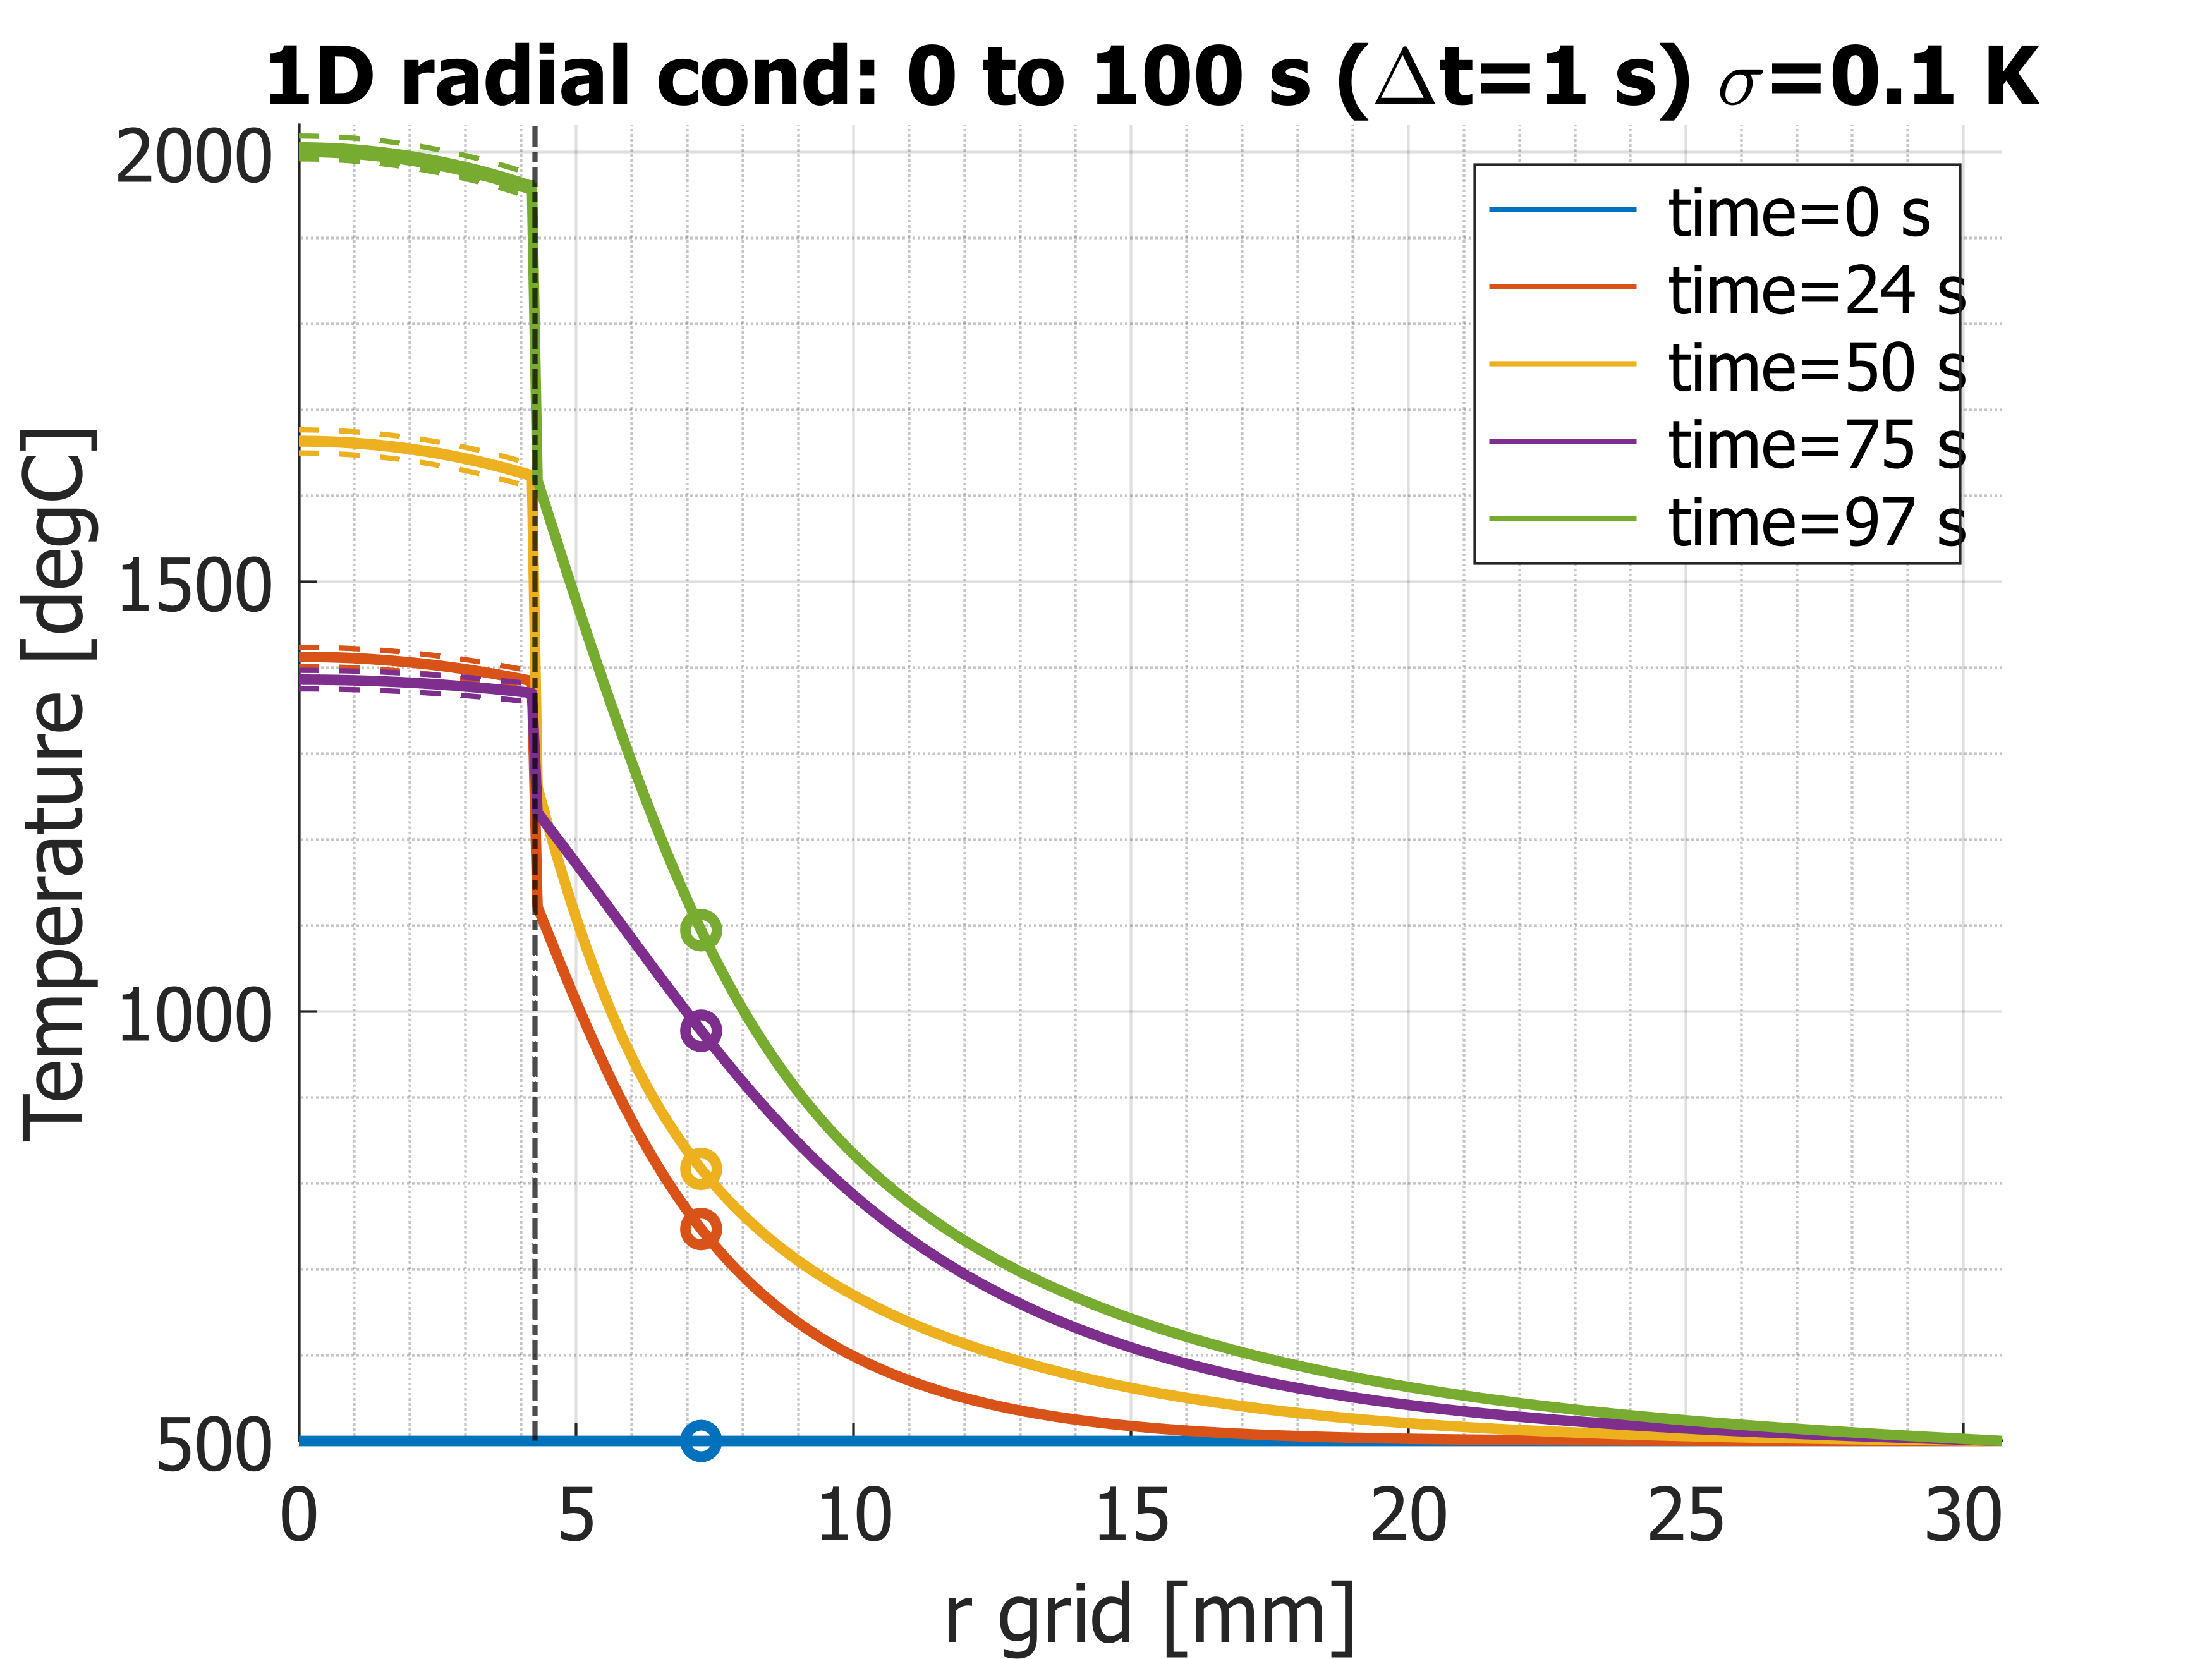

In [30]:
idx_transient_plot = [1, round(N_time/4), round(N_time/2), round(N_time*3/4), N_time-r_step]; % INPUT to be matched with time grid
myColors = [
    0 0.4470 0.7410; %
    0.8500 0.3250 0.0980; %
    0.9290 0.6940 0.1250; %
    0.4940 0.1840 0.5560; %
    0.4660 0.6740 0.1880; %
    0.3010 0.7450 0.9330; %
];

figure;
set(gcf, 'WindowState', 'maximized'); % temperature history
for m=1:M_sample
for idx=1:length(idx_transient_plot) % sensing
    scatter(1000*r_grid_total(sensor_user_input), T_transient_solution_noisy(sensor_user_input,idx_transient_plot(idx), m) - 273.15,'Linewidth',2,'MarkerEdgeColor', myColors(idx, :),'handlevisibility','off')
    hold on
end
end
for idx=1:length(idx_transient_plot) % original solution
    plot(1000*r_grid_total, T_transient_solution(:,idx_transient_plot(idx)) - 273.15,'Color', myColors(idx, :),'Linewidth',1,'displayname', strcat(' time=', num2str(time_grid(idx_transient_plot(idx))),' s'))
    hold on
end
for idx=1:length(idx_transient_plot) % reconstruction
    plot(1000*r_grid_total, T_transient_sm_mean(:,idx_transient_plot(idx)) - 273.15,'Color', myColors(idx, :),'Linewidth',2,'handlevisibility','off')
    hold on
    plot(1000*r_grid_total, T_transient_sm_mean(:,idx_transient_plot(idx)) + T_transient_sm_std(:,idx_transient_plot(idx))- 273.15,'--','Color', myColors(idx, :),'Linewidth',1,'handlevisibility','off')
    hold on
    plot(1000*r_grid_total, T_transient_sm_mean(:,idx_transient_plot(idx)) - T_transient_sm_std(:,idx_transient_plot(idx))- 273.15,'--','Color', myColors(idx, :),'Linewidth',1,'handlevisibility','off')
end
hold on
xline(1000*r_grid_total(N_grid_heater),'-.k','Linewidth',1,'handlevisibility','off')

legend('show')
xlabel('r grid [mm]')
ylabel('Temperature [degC]')
title("1D radial cond: 0 to " + num2str(time_end)+ " s (\Deltat=" + num2str(dt)+" s) \sigma="+ num2str(sigma_noise)+ " K")
set(gca,'FontSize',fontsize,'fontname','times')
xlim([0 ro_zro2*1000])
ylim([500 max(T_transient_solution, [], "all") - 273.15])
grid on
grid minor